# Imports

In [451]:
import mfl as mfl
import pandas as pd
import numpy as np
import mfl.api.data_loaders as mfldata
import nfl_data_py as nfl

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, precision_recall_curve, mean_squared_error, mean_absolute_error

from xgboost import XGBClassifier, XGBRFClassifier

from catboost import CatBoostClassifier, CatBoostRegressor

import keras
from keras.layers import Dense, ReLU, Bidirectional, Normalization, Dropout, Input
from keras.models import Sequential

from sklearn.cluster import KMeans

import requests
from bs4 import BeautifulSoup
import time

import seaborn as sns
import matplotlib.pyplot as plt

import math

# Cleaning

In [583]:
def scrape_NFL_REF_QB(player_name):

    first_name = player_name.split(' ')[0].lower()
    last_name = player_name.split(' ')[1].lower()
    player_url = f'https://www.sports-reference.com/cfb/players/{first_name}-{last_name}-1.html'
    if player_name == "Josh Allen":
        player_url = f'https://www.sports-reference.com/cfb/players/{first_name}-{last_name}-7.html'
    html_content = requests.get(player_url).text

    if len(player_name.split(' ')) > 2:
        first_name = player_name.split(' ')[0].lower()
        last_name = player_name.split(' ')[1].lower()
        suffix = player_name.split(' ')[2].lower()
        player_url = f'https://www.sports-reference.com/cfb/players/{first_name}-{last_name}-{suffix}-1.html'
        html_content = requests.get(player_url).text


    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', {'id': 'passing_standard'})

    if not table:
        for idx in range(2, 6):
            time.sleep(3)
            first_name = player_name.split(' ')[0].lower()
            last_name = player_name.split(' ')[1].lower()
            player_url = f'https://www.sports-reference.com/cfb/players/{first_name}-{last_name}-{idx}.html'
            html_content = requests.get(player_url).text
            
            soup = BeautifulSoup(html_content, 'html.parser')
            table = soup.find('table', {'id': 'passing_standard'})
            
            if not table:
                print(f"Passing stats table not found for {player_name}. Failed on index {idx}")
            else:
                print(f"Player found on index {idx}")
                break
    
    try:
        table.find_all('th')
        headers = [th.getText() for th in table.find_all('th')]
        yrs = [i for i in headers if ('2' in i) & (len(i) == 4 or len(i) == 5)]
        career_idx = headers.index(yrs[-1]) + 1
        baseline_headers = []
        headers = [th.getText() for th in table.find_all('th')]
        rows = []

        for tr in table.find_all('tr')[1:]:
            cells = [td.getText() for td in tr.find_all('td')]
            if cells: 
                rows.append(cells)

        career_stats = []

        for row in rows:
            if row.count('') == 2:
                career_stats.extend(row)
                break

        career_stats.remove('')
        career_stats.remove('')

        career_stats.append(len(yrs))
        career_stats.append(player_name)

        column_names = [
        'G',        
        'Cmp',      
        'Att',      
        'Cmp%',     
        'Yds',      
        'TD',       
        'TD%',      
        'Int',      
        'Int%',     
        'Y/A',      
        'AY/A',     
        'Y/C',      
        'Y/G',      
        'Rate',
        'seasons',
        'name'
        ]

        final = pd.DataFrame({name: [value] for name, value in zip(column_names, career_stats)})

        if len(career_stats) == len(column_names):
            final = pd.DataFrame({name: [value] for name, value in zip(column_names, career_stats)})
        else:
            print("Error: Number of stats does not match number of column names.")

        return final    
    except:
        print(f"FAILED: On {player_name}")

In [584]:
scrape_NFL_REF_QB("Josh Allen")

,G,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,seasons,name
0,27,365,649,56.2,5066,44,6.8,21,3.2,7.8,7.71,13.9,187.6,137.7,3,Josh Allen


In [285]:
years = range(2010, 2023)
data = nfl.import_weekly_data(years)
draft = nfl.import_draft_picks(years)

Downcasting floats.


In [117]:
draft.columns

Index(['season', 'round', 'pick', 'team', 'gsis_id', 'pfr_player_id',
       'cfb_player_id', 'pfr_player_name', 'hof', 'position', 'category',
       'side', 'college', 'age', 'to', 'allpro', 'probowls', 'seasons_started',
       'w_av', 'car_av', 'dr_av', 'games', 'pass_completions', 'pass_attempts',
       'pass_yards', 'pass_tds', 'pass_ints', 'rush_atts', 'rush_yards',
       'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'def_solo_tackles',
       'def_ints', 'def_sacks'],
      dtype='object')

In [119]:
draft[draft['pfr_player_name'] == "Cam Newton"]['seasons_started']

8832    9
Name: seasons_started, dtype: int32

In [509]:
data.columns

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [286]:
all_qbs = draft[draft['position'] == 'QB']
all_qb_names = all_qbs['pfr_player_name'].unique().tolist()

In [8]:
raw_data = []
for name in all_qb_names:
    print(name)
    raw_data.append(scrape_NFL_REF_QB(player_name=name))
    time.sleep(3)

Sam Bradford
Tim Tebow
Jimmy Clausen
Colt McCoy
Mike Kafka
John Skelton
Passing stats table not found for John Skelton. Failed on index 2
Passing stats table not found for John Skelton. Failed on index 3
Passing stats table not found for John Skelton. Failed on index 4
Passing stats table not found for John Skelton. Failed on index 5
FAILED: On John Skelton
Jonathan Crompton
Rusty Smith
Dan LeFevour
Tony Pike
Levi Brown
Sean Canfield
Zac Robinson
Cam Newton
Jake Locker
Blaine Gabbert
Christian Ponder
Andy Dalton
Colin Kaepernick
Ryan Mallett
Ricky Stanzi
T.J. Yates
Passing stats table not found for T.J. Yates. Failed on index 2
Passing stats table not found for T.J. Yates. Failed on index 3
Passing stats table not found for T.J. Yates. Failed on index 4
Passing stats table not found for T.J. Yates. Failed on index 5
FAILED: On T.J. Yates
Nathan Enderle
Tyrod Taylor
Greg McElroy
Andrew Luck
Robert Griffin III
Ryan Tannehill
Brandon Weeden
Brock Osweiler
Russell Wilson
Nick Foles
Kirk Co

In [11]:
extracted_data = pd.concat([i for i in raw_data if i is not None])

In [168]:
draft[draft['position'] == 'QB']['seasons_started'].value_counts(normalize=True).iloc[0:4].sum()

0.8187919463087249

In [169]:
draft[draft['position'] == 'QB']['seasons_started'].value_counts(normalize=True).iloc[4:].sum()

0.18120805369127518

In [15]:
print(raw_data.__len__())
print(extracted_data.shape[0])

149
133


In [16]:
processing = data[data['player_display_name'].isin(all_qb_names)].sort_values(['player_display_name', 'season']).groupby(['player_display_name', 'recent_team'], sort=False).agg({'season':'nunique'}).reset_index()
final_years_1st_team = processing.groupby('player_display_name').agg({'season':'first'})

In [17]:
draft_teams = data[data['player_display_name'].isin(all_qb_names)].groupby(['player_display_name']).agg({'recent_team':'first'})

In [18]:
df_with_teams = pd.merge(left=extracted_data, 
                         right=draft_teams, 
                         left_on='name',
                         right_on='player_display_name',
                         how='left')

In [281]:
draft.columns

Index(['season', 'round', 'pick', 'team', 'gsis_id', 'pfr_player_id',
       'cfb_player_id', 'pfr_player_name', 'hof', 'position', 'category',
       'side', 'college', 'age', 'to', 'allpro', 'probowls', 'seasons_started',
       'w_av', 'car_av', 'dr_av', 'games', 'pass_completions', 'pass_attempts',
       'pass_yards', 'pass_tds', 'pass_ints', 'rush_atts', 'rush_yards',
       'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'def_solo_tackles',
       'def_ints', 'def_sacks'],
      dtype='object')

In [19]:
df_with_draft_teams = pd.merge(left=all_qbs[['pfr_player_name', 'round', 'pick', 'season', 'allpro', 'seasons_started']],
                               right=df_with_teams,
                               left_on='pfr_player_name',
                               right_on='name',
                               how='left'
                               )

In [20]:
final_years_1st_team = final_years_1st_team.rename(columns={'season':'seasons_with_draft_team'})

In [21]:
final = pd.merge(left=df_with_draft_teams,
                 right=final_years_1st_team,
                 left_on='name',
                 right_on='player_display_name',
                 how='left')

In [22]:
final = final[['pfr_player_name', 'round', 'pick', 'season', 'G', 'Cmp', 'Att', 'Cmp%',
       'Yds', 'TD', 'TD%', 'Int', 'Int%', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate',
       'seasons','recent_team', 'seasons_with_draft_team']]

In [23]:
final = final.rename(columns={'season':'draft_year','pfr_player_name':'player_name', 'seasons':'college_seasons'})

In [260]:
import nfl_data_py as nfl

In [261]:
nfl.import_rosters(seasons=[2024])

AttributeError: module 'nfl_data_py' has no attribute 'import_rosters'

In [120]:
draft.columns

Index(['season', 'round', 'pick', 'team', 'gsis_id', 'pfr_player_id',
       'cfb_player_id', 'pfr_player_name', 'hof', 'position', 'category',
       'side', 'college', 'age', 'to', 'allpro', 'probowls', 'seasons_started',
       'w_av', 'car_av', 'dr_av', 'games', 'pass_completions', 'pass_attempts',
       'pass_yards', 'pass_tds', 'pass_ints', 'rush_atts', 'rush_yards',
       'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'def_solo_tackles',
       'def_ints', 'def_sacks'],
      dtype='object')

In [122]:
final = pd.read_csv("~/Desktop/mfl_project/mfl/data/full_qb_dataset_v2.csv")

In [ ]:
pd.merge(left=final, right=draft.drop(['round', 'pick']), left_on='player_name', right_on='pfr_player_name', how='left')

,player_name,round_x,pick_x,draft_year,G,Cmp,Att,Cmp%,Yds,TD,...,pass_ints,rush_atts,rush_yards,rush_tds,receptions,rec_yards,rec_tds,def_solo_tackles,def_ints,def_sacks
0,Sam Bradford,1,1,2010,31.0,604.0,893.0,67.6,8403.0,88.0,...,61.0,146.0,340.0,2.0,1.0,5.0,0.0,NaN,NaN,NaN
1,Tim Tebow,1,25,2010,55.0,661.0,995.0,66.4,9285.0,88.0,...,9.0,197.0,989.0,12.0,0.0,0.0,0.0,1.0,NaN,NaN
2,Jimmy Clausen,2,48,2010,35.0,695.0,1110.0,62.6,8148.0,60.0,...,14.0,37.0,102.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
3,Colt McCoy,3,85,2010,53.0,1157.0,1645.0,70.3,13253.0,112.0,...,32.0,175.0,582.0,2.0,2.0,8.0,0.0,1.0,NaN,NaN
4,Mike Kafka,4,122,2010,30.0,408.0,637.0,64.1,4265.0,19.0,...,2.0,3.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,C.J. Beathard,3,104,2017,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,64.0,266.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN
145,Joshua Dobbs,4,135,2017,37.0,614.0,999.0,61.5,7138.0,53.0,...,15.0,100.0,520.0,8.0,0.0,0.0,0.0,NaN,NaN,NaN
146,Nathan Peterman,5,171,2017,36.0,398.0,663.0,60.0,5236.0,47.0,...,13.0,24.0,87.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN
147,Brad Kaaya,6,215,2017,38.0,721.0,1189.0,60.6,9972.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
final[final['player_name'] == "Cam Newton"].columns

Index(['player_name', 'round', 'pick', 'draft_year', 'G', 'Cmp', 'Att', 'Cmp%',
       'Yds', 'TD', 'TD%', 'Int', 'Int%', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate',
       'college_seasons', 'recent_team', 'seasons_with_draft_team'],
      dtype='object')

In [27]:
final.to_csv("~/Desktop/mfl_project/mfl/data/full_qb_dataset_v2.csv",index=False)

# Modeling Pipeline

In [474]:
final_with_responses[final_with_responses['seasons_started'] >= 3].shape

(42, 23)

In [475]:
final_with_responses[final_with_responses['seasons_started'] < 3].shape

(107, 23)

In [765]:
def map_years_with_draft_team(x):
        if x >= 4:
            return 1
        else: 
            return 0
        
def map_seasons_started(x):
     if x >=3: 
          return 1
     else:
          return 0

    
def score(y_test, y_probs, y_preds):
    accuracy = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    roc_auc = roc_auc_score(y_test, y_probs)
    recall = recall_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)

    metric_dict = {
        'accuracy' : accuracy,
        'f1' : f1,
        'roc_auc': roc_auc,
        'recall': recall,
        'precision': precision
    }

    return metric_dict


def catboost(df, year_cutoff=2019, feature_set=None, kfold=False, folds=2):

    df = df.dropna()
    df = df[df['draft_year'] <= year_cutoff]

    if feature_set is None:
        X = df.drop(['player_name', 'pfr_player_name', 'seasons_with_draft_team', 'seasons_started'],axis=1)
        y = df['seasons_started']
    elif feature_set is not None:
        pass
    
    X = X
    y = y
    y_mapped = y.apply(map_years_with_draft_team)
    y_mapped = y.apply(map_seasons_started)

    X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=.25, stratify=y_mapped, shuffle=True)

    model = CatBoostClassifier(one_hot_max_size=15,
                                iterations=500, 
                                cat_features=X.select_dtypes(include='object').columns.tolist())
    
    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:,1]

    metrics = score(y_test, y_probs, y_preds)
    
    model.fit(X, y_mapped)
    fit_model = model
    model_results = pd.DataFrame(metrics, index=[0])

    return model, model_results
    

def predict_2025_qb(model, player_name, round, pick, recent_team, predictors, season=2025):
    season = season
    variant_features = ['round', 'pick', 'draft_year']
    available_features = np.setdiff1d(model.feature_names_[:-1], variant_features).tolist()
    predictors = predictors[available_features]
    
    initial_features = pd.DataFrame({
        'round' : round,
        'pick' : pick,
        'draft_year' : season
    }, index=[0])
    
    processing = pd.concat([initial_features, predictors], axis=1)
    processing['recent_team'] = recent_team
    prediction = model.predict_proba(processing).tolist()[0][1]

    result_dict = {
         'player_name' : player_name,
         'round' : round,
         'pick' : pick,
         'prob' : prediction
    }
    
    return pd.DataFrame(result_dict, index=[0])

In [763]:
math.ceil(257/33)

8

In [ ]:
final_with_responses = pd.merge(left=final, 
                                right=draft[['pfr_player_name', 'seasons_started']], 
                                left_on='player_name',
                                right_on='pfr_player_name',
                                how='left')

In [ ]:
draft_order = pd.read_excel("~/Downloads/Top Prospects for the 2025 NFL Draft-2.xlsx", sheet_name='2025 NFL Draft Order', skiprows=1)

In [ ]:
model, results = catboost(final_with_responses, year_cutoff=2018)

In [ ]:
abbreviations = ['TEN', 'CLE', 'NYG', 'NE', 'JAX', 'LV', 'NYJ', 'CAR', 'NO', 'CHI', 'SF', 'DAL', 'MIA', 'IND', 'ATL', 'ARI', 'CIN', 'SEA', 'TB', 'DEN', 'PIT', 'LAC', 'GB', 'MIN', 'HOU', 'LAR', 'BAL', 'DET', 'WAS', 'BUF', 'KC', 'PHI']
teams = draft_order['Team'].unique()

team_mapping = {i:j for i,j in zip(teams, abbreviations)}

draft_order['abbrev'] = draft_order['Team'].apply(lambda team: team_mapping[team])

In [753]:
math.ceil(224/32)

7

In [769]:
def predict_full_draft(player_name, draft_order):
    season = 2025
    player_data = mfldata.scrape_NFL_REF_QB(player_name)
    results = []
    for pick, team in zip(draft_order['Pick'], draft_order['abbrev']):
        if pick <= 224:
            round = math.ceil(pick/32)
        else:
            round = 7
        result = predict_2025_qb(model=model, 
                                 player_name=player_name, 
                                 round=round, 
                                 pick=pick,
                                 recent_team=team,
                                 predictors=player_data,
                                 season=season)
        results.append(result)
    final = pd.concat(results)

    return final

In [793]:
qbs_of_interest = [
    'Cameron Ward',
    'Shedeur Sanders',
    'Jalen Milroe',
    'Jaxson Dart',
    'Tyler Shough',
    'Quinn Ewers'
]

In [794]:
modeled_results = pd.concat([predict_full_draft(player_name=qb, draft_order=draft_order) for qb in qbs_of_interest])

In [811]:
ward_ewers = ['Cameron Ward', 'Shedeur Sanders']

In [819]:
modeled_results

,player_name,round,pick,prob
0,Cameron Ward,1,1,0.813851
0,Cameron Ward,1,2,0.766643
0,Cameron Ward,1,3,0.897860
0,Cameron Ward,1,4,0.861752
0,Cameron Ward,1,5,0.864010
...,...,...,...,...
0,Quinn Ewers,7,253,0.165985
0,Quinn Ewers,7,254,0.165985
0,Quinn Ewers,7,255,0.076606
0,Quinn Ewers,7,256,0.165985


In [822]:
idx = modeled_results.groupby(['player_name', 'round'])['prob'].idxmax()
modeled_results.loc[idx, ['player_name', 'round', 'pick', 'prob']].reset_index(drop=True)


,player_name,round,pick,prob
0,Cameron Ward,1,1,0.813851
1,Cameron Ward,1,2,0.766643
2,Cameron Ward,1,3,0.897860
3,Cameron Ward,1,4,0.861752
4,Cameron Ward,1,5,0.864010
...,...,...,...,...
64759,Quinn Ewers,7,253,0.165985
64760,Quinn Ewers,7,254,0.165985
64761,Quinn Ewers,7,255,0.076606
64762,Quinn Ewers,7,256,0.165985


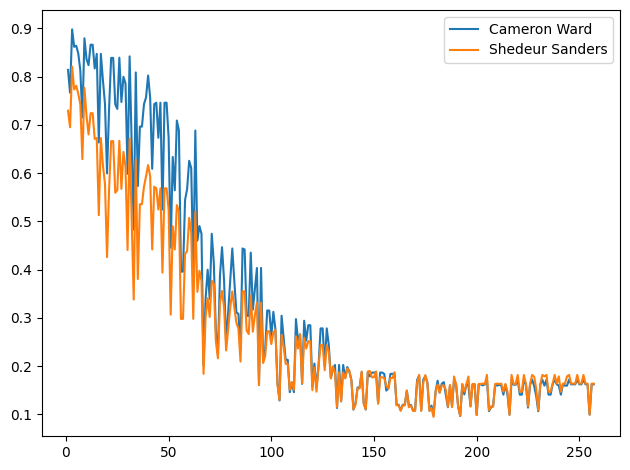

In [812]:
for qb in ward_ewers:
    cut_qb = modeled_results[modeled_results['player_name'] == qb]
    plt.plot(cut_qb['pick'], cut_qb['prob'])
    plt.tight_layout()
plt.legend(ward_ewers)
plt.show()

In [679]:
final = pd.read_csv("/Users/benstager/Desktop/mfl_project/mfl/data/full_qb_dataset_v2.csv")

In [719]:
results

,accuracy,f1,roc_auc,recall,precision
0,0.842105,0.8,0.940476,0.857143,0.75


In [720]:
predict_2025_qb(model, player_name='Shedeur Sanders', recent_team='NO', round=1, pick=9, season=2025)

0.7766189684988929

In [727]:
draft_order = pd.read_excel("~/Downloads/Top Prospects for the 2025 NFL Draft-2.xlsx", sheet_name='2025 NFL Draft Order', skiprows=1)

In [728]:
draft_order['Team'].unique()

array(['Tennessee Titans', 'Cleveland Browns', 'New York Giants',
       'New England Patriots', 'Jacksonville Jaguars',
       'Las Vegas Raiders', 'New York Jets', 'Carolina Panthers',
       'New Orleans Saints', 'Chicago Bears', 'San Francisco 49ers',
       'Dallas Cowboys', 'Miami Dolphins', 'Indianapolis Colts',
       'Atlanta Falcons', 'Arizona Cardinals', 'Cincinnati Bengals',
       'Seattle Seahawks', 'Tampa Bay Buccaneers', 'Denver Broncos',
       'Pittsburgh Steelers', 'Los Angeles Chargers', 'Green Bay Packers',
       'Minnesota Vikings', 'Houston Texans', 'Los Angeles Rams',
       'Baltimore Ravens', 'Detroit Lions', 'Washington Commanders',
       'Buffalo Bills', 'Kansas City Chiefs', 'Philadelphia Eagles'],
      dtype=object)

In [729]:
abbreviations = ['TEN', 'CLE', 'NYG', 'NE', 'JAX', 'LV', 'NYJ', 'CAR', 'NO', 'CHI', 'SF', 'DAL', 'MIA', 'IND', 'ATL', 'ARI', 'CIN', 'SEA', 'TB', 'DEN', 'PIT', 'LAC', 'GB', 'MIN', 'HOU', 'LAR', 'BAL', 'DET', 'WAS', 'BUF', 'KC', 'PHI']
teams = draft_order['Team'].unique()

team_mapping = {i:j for i,j in zip(teams, abbreviations)}

draft

In [732]:
draft_order['abbrev'] = draft_order['Team'].apply(lambda team: team_mapping[team])

In [733]:
draft_order

,Rounds,Pick,Team,Position,Name,School,abbrev
0,1st Round,1,Tennessee Titans,NaN,NaN,NaN,TEN
1,Updated 3/16/25,2,Cleveland Browns,NaN,NaN,NaN,CLE
2,NaN,3,New York Giants,NaN,NaN,NaN,NYG
3,NaN,4,New England Patriots,NaN,NaN,NaN,NE
4,NaN,5,Jacksonville Jaguars,NaN,NaN,NaN,JAX
...,...,...,...,...,...,...,...
252,NaN,253,Miami Dolphins,NaN,NaN,NaN,MIA
253,NaN,254,New Orleans Saints,NaN,NaN,NaN,NO
254,NaN,255,Cleveland Browns,NaN,NaN,NaN,CLE
255,NaN,256,Los Angeles Chargers,NaN,NaN,NaN,LAC


# Let's try to predict out of sample

In [55]:
prospect_names = pd.read_excel("~/Downloads/Top Prospects for the 2025 NFL Draft.xlsx", sheet_name=0, skiprows=2)

In [242]:
draft_order = pd.read_excel("~/Downloads/Top Prospects for the 2025 NFL Draft.xlsx", sheet_name=2, skiprows=1)[['Pick', 'Team']]

In [243]:
draft_order.head(50)

,Pick,Team
0,1,Tennessee Titans
1,2,Cleveland Browns
2,3,New York Giants
3,4,New England Patriots
4,5,Jacksonville Jaguars
5,6,Las Vegas Raiders
6,7,New York Jets
7,8,Carolina Panthers
8,9,New Orleans Saints
9,10,Chicago Bears


In [56]:
qbs_2025 = prospect_names[prospect_names['Position'] == "QB"]

In [136]:
qbs_2025['Name']

8             Cam Ward
25     Shedeur Sanders
66         Jaxson Dart
81        Jalen Milroe
98         Quinn Ewers
105        Will Howard
124       Tyler Shough
141     Dillon Gabriel
150        Kyle McCord
200      Riley Leonard
245        Max Brosmer
246      Kurtis Rourke
248       Graham Mertz
275         Brady Cook
305     Cameron Rising
313        Will Rogers
347       Seth Henigan
421      Donovan Smith
424       KJ Jefferson
425      DJ Ulagalelei
426    Taylor Elgersma
434         Cam Miller
435      Payton Thorne
444      Ethan Garbers
Name: Name, dtype: object

# Analysis

In [288]:
final = pd.read_csv("/Users/benstager/Desktop/mfl_project/mfl/data/full_qb_dataset_v2.csv")

In [293]:
max(final['draft_year'])

2022

In [296]:
final.columns

Index(['player_name', 'round', 'pick', 'draft_year', 'G', 'Cmp', 'Att', 'Cmp%',
       'Yds', 'TD', 'TD%', 'Int', 'Int%', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate',
       'college_seasons', 'recent_team', 'seasons_with_draft_team'],
      dtype='object')

In [295]:
draft.columns

Index(['season', 'round', 'pick', 'team', 'gsis_id', 'pfr_player_id',
       'cfb_player_id', 'pfr_player_name', 'hof', 'position', 'category',
       'side', 'college', 'age', 'to', 'allpro', 'probowls', 'seasons_started',
       'w_av', 'car_av', 'dr_av', 'games', 'pass_completions', 'pass_attempts',
       'pass_yards', 'pass_tds', 'pass_ints', 'rush_atts', 'rush_yards',
       'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'def_solo_tackles',
       'def_ints', 'def_sacks'],
      dtype='object')

In [644]:
final_with_responses = pd.merge(left=final, 
                                right=draft[['pfr_player_name', 'allpro', 'seasons_started', 'probowls', 'w_av']], 
                                left_on='player_name',
                                right_on='pfr_player_name',
                                how='left')

### Teams who picked qbs most

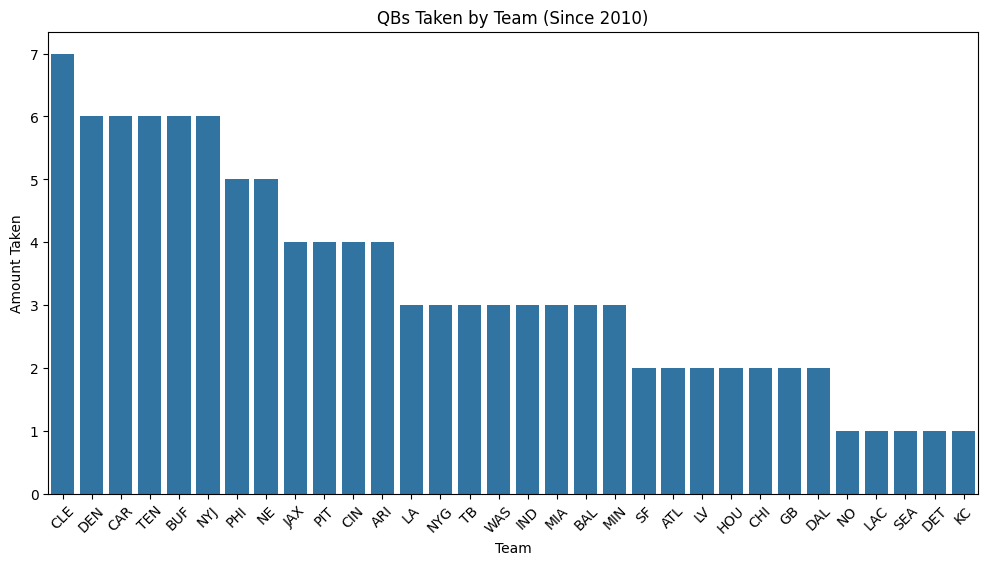

In [518]:
plt.figure(figsize=(12, 6))
sns.countplot(data=final, x='recent_team', order=final['recent_team'].value_counts().index)
plt.xticks(rotation=45)
plt.title("QBs Taken by Team (Since 2010)")
plt.xlabel('Team')
plt.ylabel('Amount Taken')
plt.show()

<Axes: xlabel='round', ylabel='Density'>

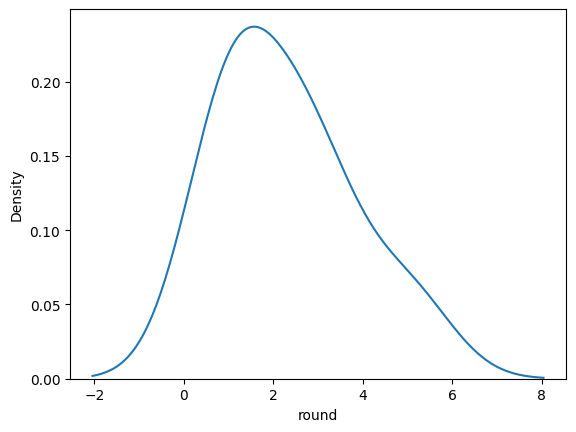

In [514]:
sns.kdeplot(data=final[final['recent_team'] == 'CLE'], x='round')

<Axes: xlabel='round', ylabel='Density'>

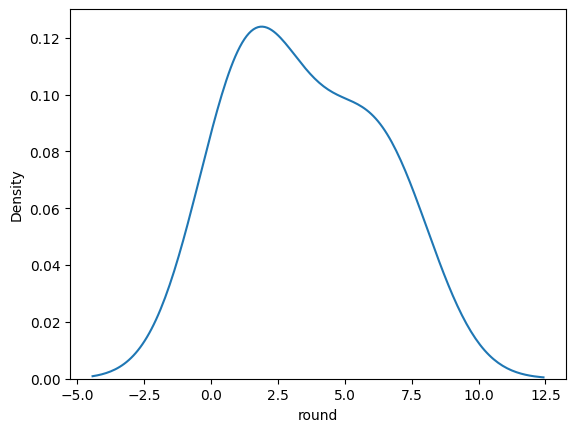

In [516]:
sns.kdeplot(data=final[final['recent_team'] == 'NYJ'], x='round')

### Qbs picked by round

,player_name,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,...,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,college_seasons,recent_team,seasons_with_draft_team
0,Sam Bradford,1,1,2010,31.0,604.0,893.0,67.6,8403.0,88.0,...,16.0,1.8,9.4,10.57,13.9,271.1,175.6,3.0,LA,4.0
1,Tim Tebow,1,25,2010,55.0,661.0,995.0,66.4,9285.0,88.0,...,16.0,1.6,9.3,10.38,14.0,168.8,170.8,4.0,DEN,2.0
2,Jimmy Clausen,2,48,2010,35.0,695.0,1110.0,62.6,8148.0,60.0,...,27.0,2.4,7.3,7.33,11.7,232.8,137.2,3.0,CAR,1.0
3,Colt McCoy,3,85,2010,53.0,1157.0,1645.0,70.3,13253.0,112.0,...,45.0,2.7,8.1,8.19,11.5,250.1,155.0,4.0,CLE,3.0
4,Mike Kafka,4,122,2010,30.0,408.0,637.0,64.1,4265.0,19.0,...,20.0,3.1,6.7,5.88,10.5,142.2,123.9,4.0,PHI,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,C.J. Beathard,3,104,2017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,Joshua Dobbs,4,135,2017,37.0,614.0,999.0,61.5,7138.0,53.0,...,29.0,2.9,7.1,6.90,11.6,192.9,133.2,4.0,PIT,2.0
146,Nathan Peterman,5,171,2017,36.0,398.0,663.0,60.0,5236.0,47.0,...,17.0,2.6,7.9,8.16,13.2,145.4,144.6,4.0,BUF,2.0
147,Brad Kaaya,6,215,2017,38.0,721.0,1189.0,60.6,9972.0,69.0,...,24.0,2.0,8.4,8.64,13.8,262.4,146.2,3.0,NaN,NaN


1


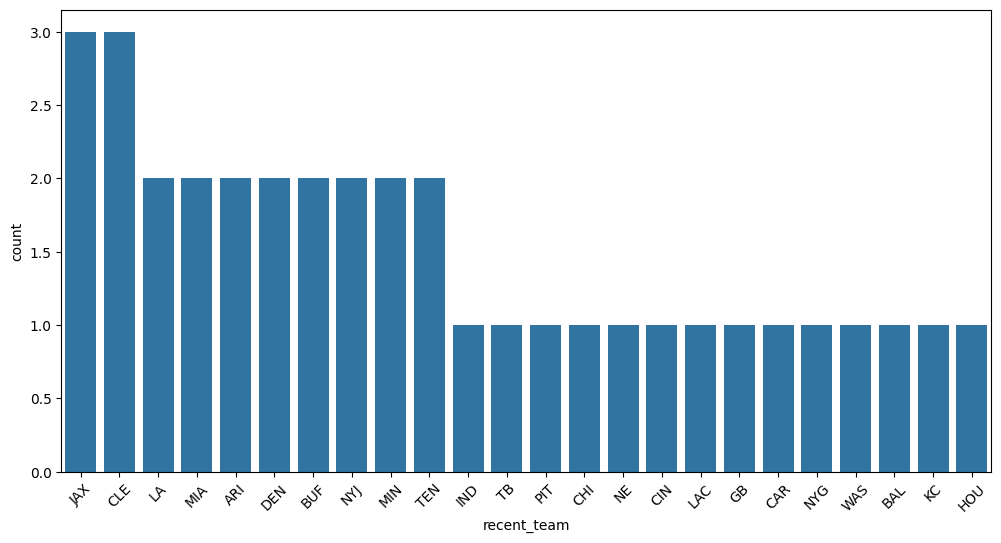

2


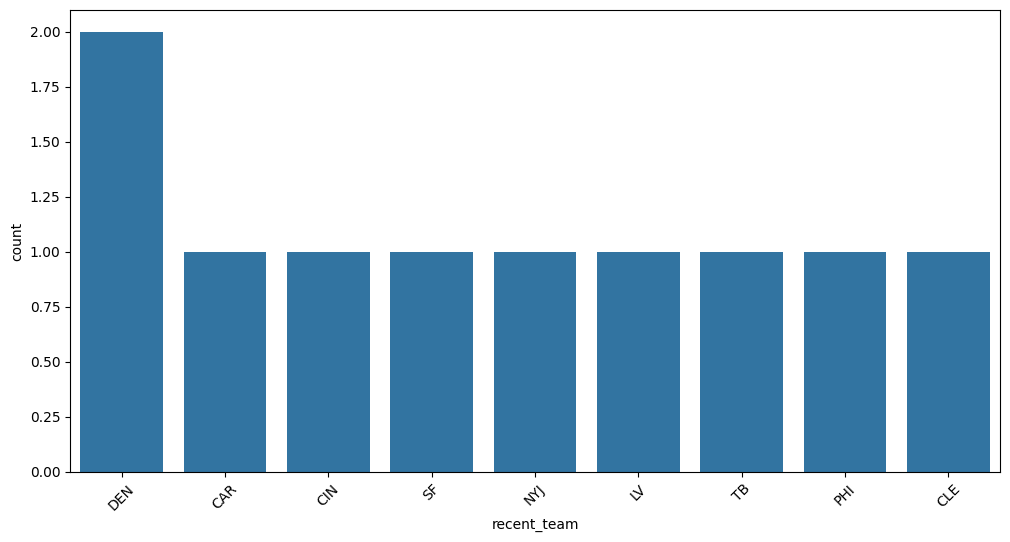

3


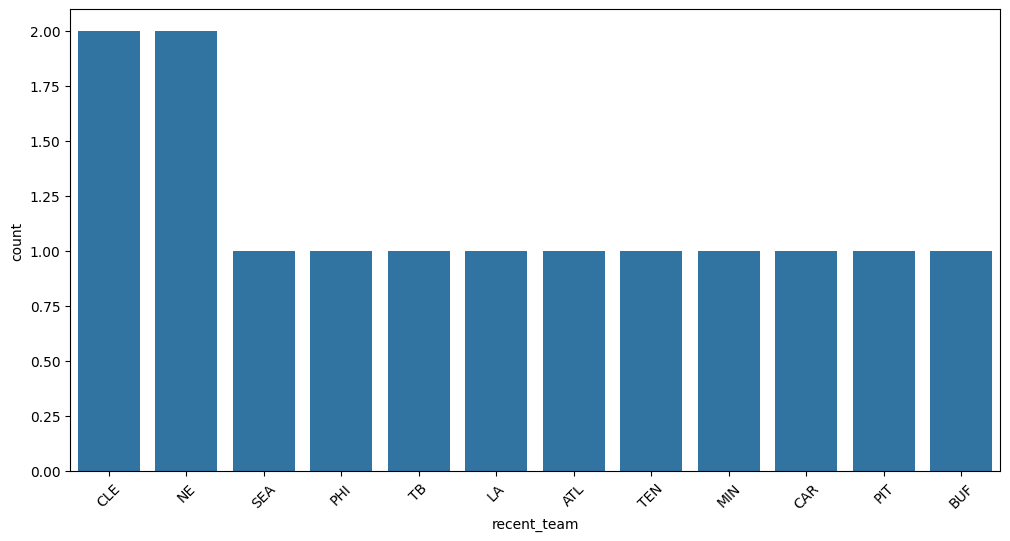

4


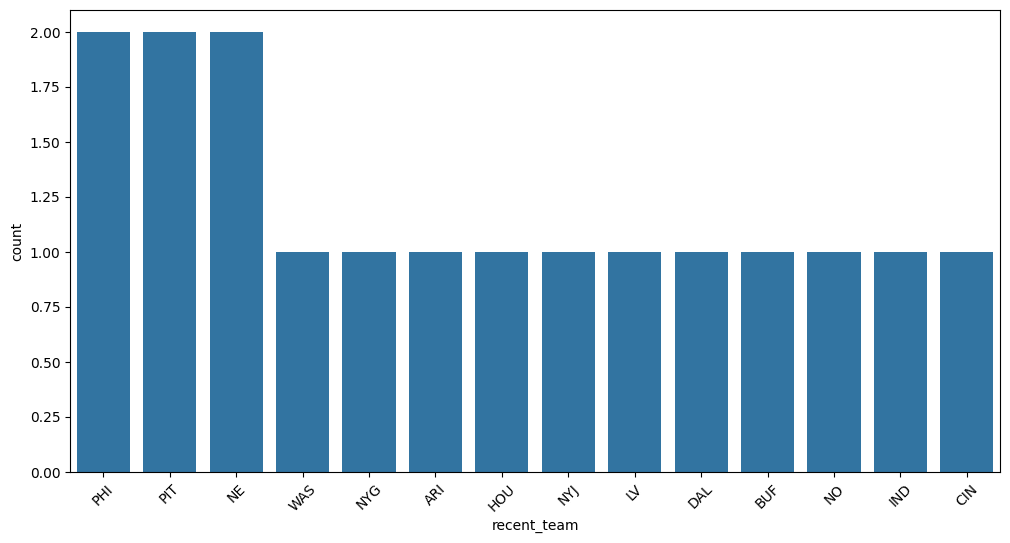

5


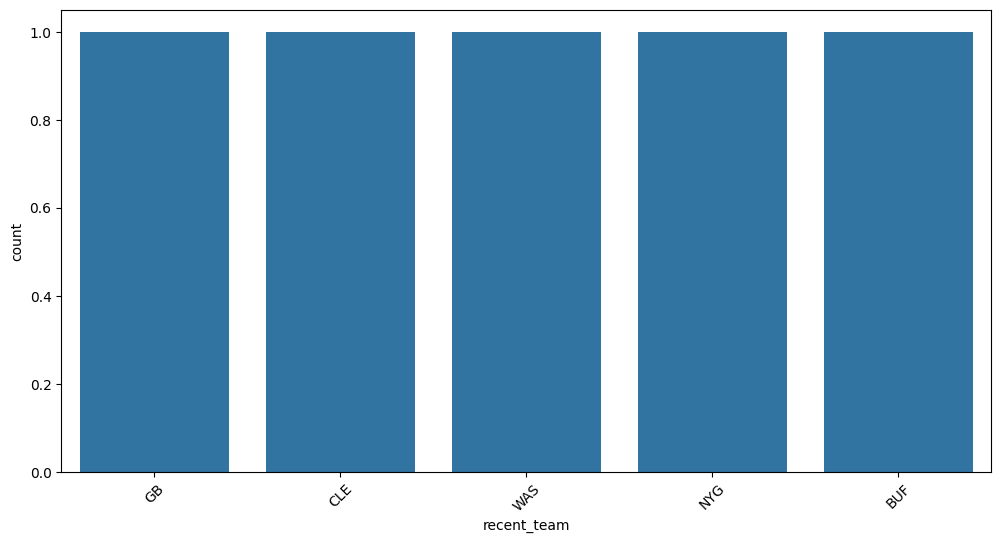

6


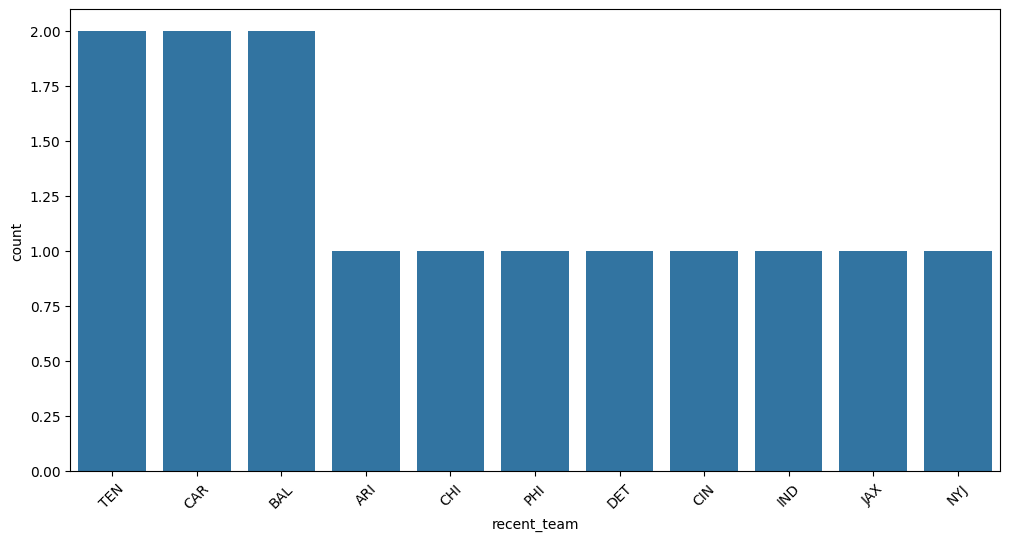

7


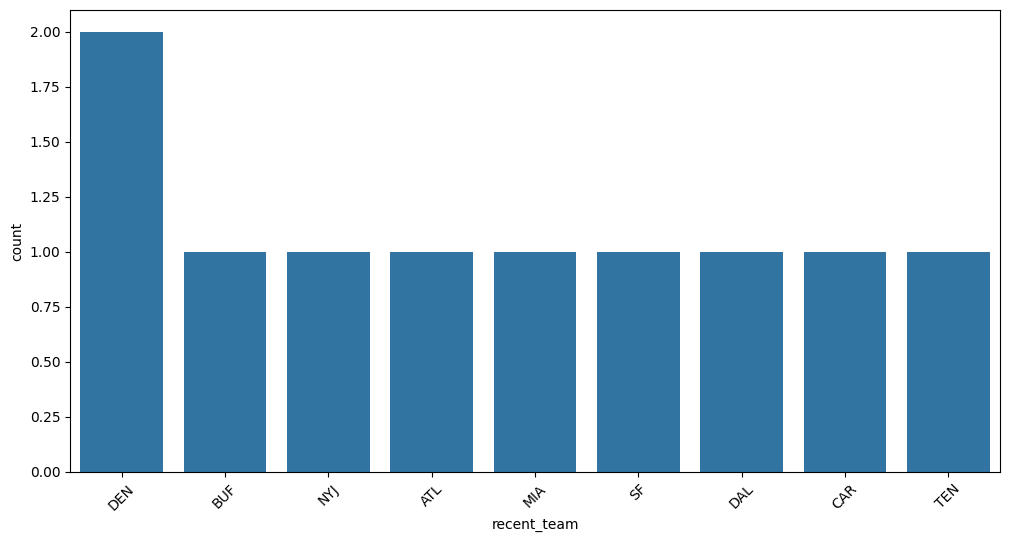

In [366]:
for round in final['round'].unique():
    print(round)
    cut = final[final['round'] == round]
    plt.figure(figsize=(12, 6))
    sns.countplot(data=cut, x='recent_team', order=cut['recent_team'].value_counts().index)
    plt.xticks(rotation=45)
    plt.show()

### Average seasons started by round

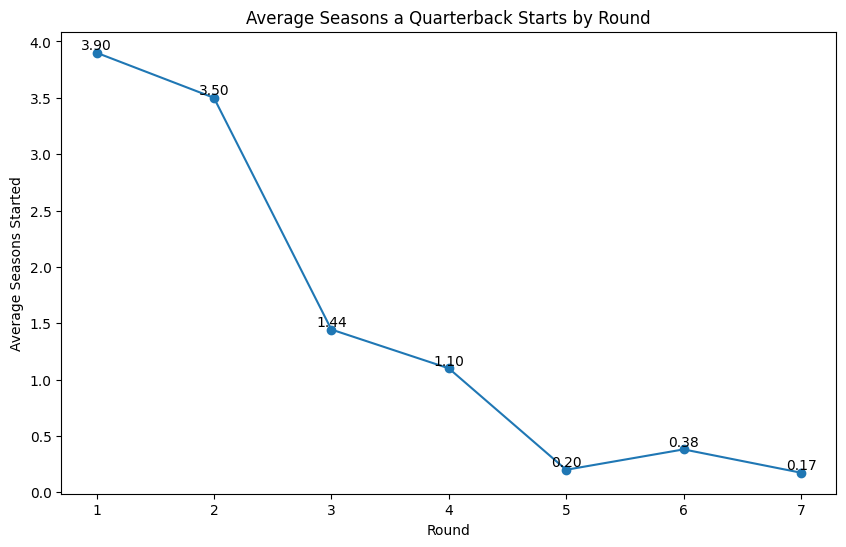

In [520]:
import matplotlib.pyplot as plt

means = final_with_responses.groupby('round')['seasons_started'].mean()

plt.figure(figsize=(10, 6))
plt.plot(means.index, means.values, marker='o')

for x, y in zip(means.index, means.values):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

plt.title("Average Seasons a Quarterback Starts by Round")
plt.xlabel('Round')
plt.ylabel('Average Seasons Started')
plt.show()

In [527]:
final[final['TD%'] == 100]

,player_name,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,...,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,college_seasons,recent_team,seasons_with_draft_team
128,Josh Allen,1,7,2018,44.0,1.0,1.0,100.0,9.0,1.0,...,0.0,0.0,9.0,29.0,9.0,0.2,505.6,4.0,BUF,5.0


In [545]:
no_JA = final_with_responses[final_with_responses['player_name'] != 'Josh Allen']

In [ ]:
no_JA.groupby

<Axes: xlabel='round'>

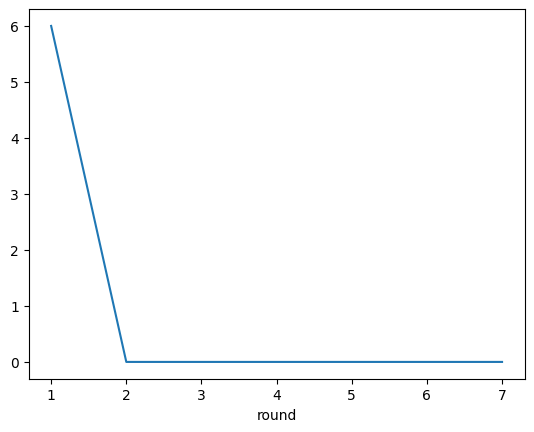

In [651]:
final_with_responses.groupby('round')['allpro'].sum().plot()

<Axes: xlabel='round'>

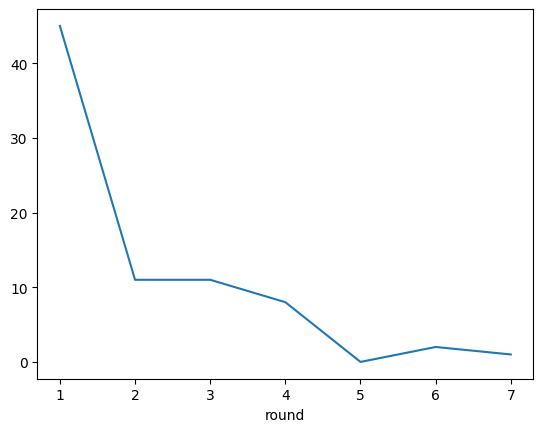

In [ ]:
final_with_responses.groupby('round')['probowls'].sum().plot()

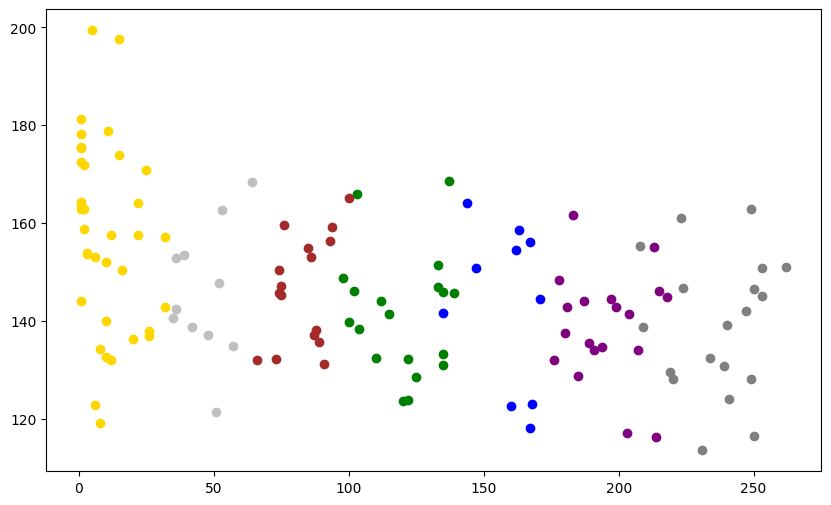

In [542]:
round_colors = {
    1: 'gold',
    2: 'silver',
    3: 'brown',
    4: 'green',
    5: 'blue',
    6: 'purple',
    7: 'gray'
}

# Create scatter plot
plt.figure(figsize=(10, 6))
for r in range(1, 8):
    subset = no_JA[no_JA['round'] == r]
    plt.scatter(subset['pick'], subset['Rate'],
                label=f'Round {r}',
                color=round_colors[r])

In [552]:
final_with_responses.columns

Index(['player_name', 'round', 'pick', 'draft_year', 'G', 'Cmp', 'Att', 'Cmp%',
       'Yds', 'TD', 'TD%', 'Int', 'Int%', 'Y/A', 'AY/A', 'Y/C', 'Y/G', 'Rate',
       'college_seasons', 'recent_team', 'seasons_with_draft_team',
       'pfr_player_name', 'seasons_started'],
      dtype='object')

In [ ]:
final_with_responses['']

<Axes: >

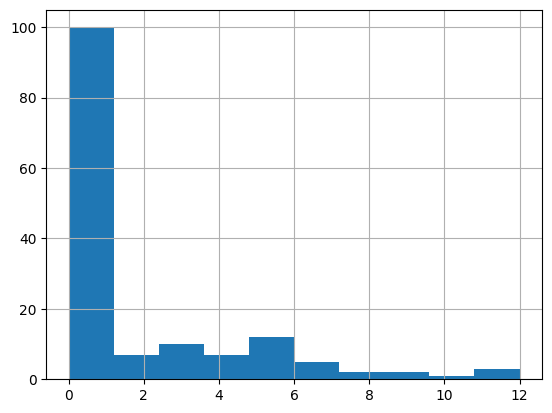

In [548]:
final_with_responses['seasons_started'].hist()

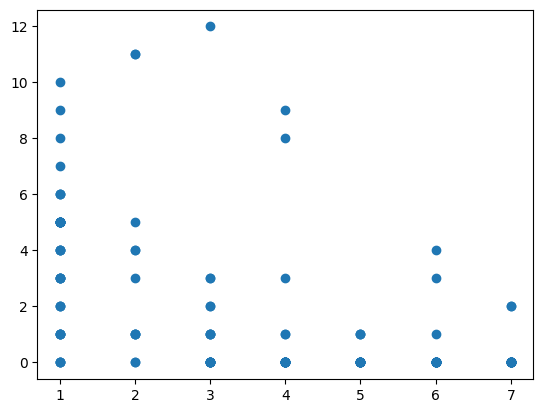

In [547]:
plt.scatter(no_JA['round'], no_JA['seasons_started'])

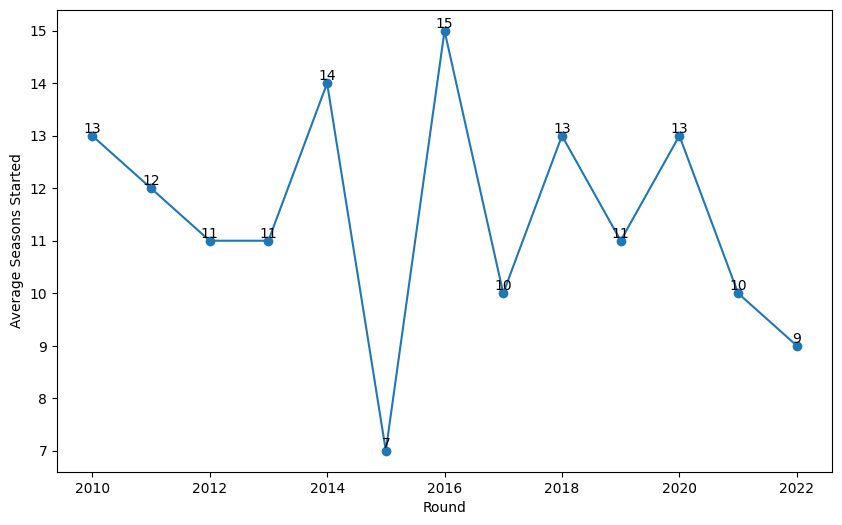

In [385]:
import matplotlib.pyplot as plt

years = final.groupby('draft_year')['player_name'].count()

plt.figure(figsize=(10, 6))
plt.plot(years.index, years.values, marker='o')

for x, y in zip(years.index, years.values):
    plt.text(x, y, f'{y:}', ha='center', va='bottom')

plt.xlabel('Round')
plt.ylabel('Average Seasons Started')
plt.show()

<Axes: xlabel='draft_year'>

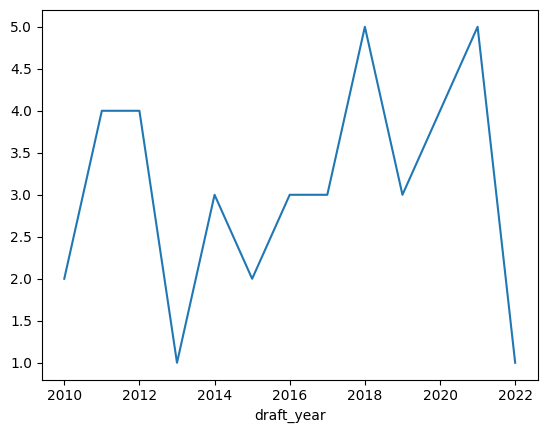

In [391]:
final[final['round'] == 1].groupby('draft_year')['player_name'].count().plot()

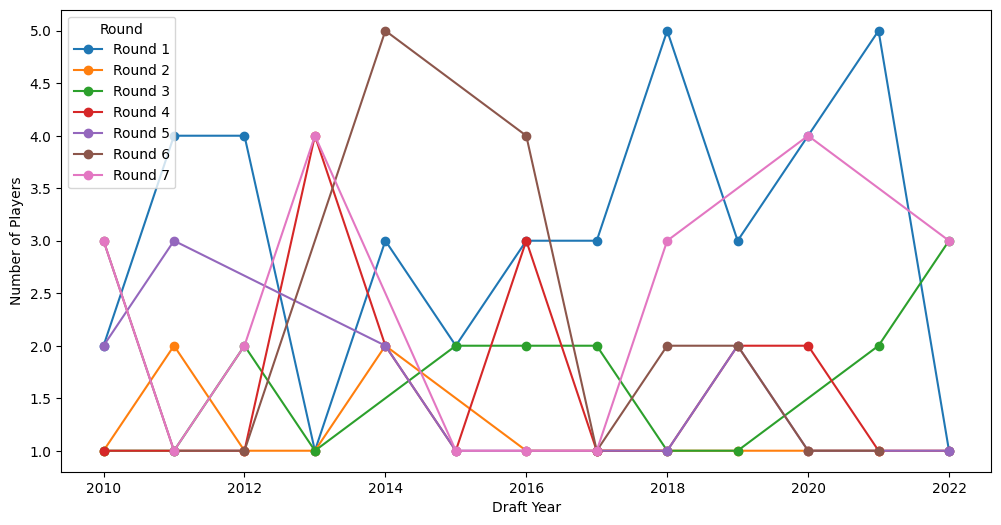

In [390]:
import matplotlib.pyplot as plt

counts = final.groupby(['draft_year', 'round'])['player_name'].count().reset_index()

plt.figure(figsize=(12, 6))
for rnd in counts['round'].unique():
    subset = counts[counts['round'] == rnd]
    plt.plot(subset['draft_year'], subset['player_name'], marker='o', label=f'Round {rnd}')

plt.xlabel('Draft Year')
plt.ylabel('Number of Players')
plt.legend(title='Round')
plt.show()

In [394]:
all_qbs.columns

Index(['season', 'round', 'pick', 'team', 'gsis_id', 'pfr_player_id',
       'cfb_player_id', 'pfr_player_name', 'hof', 'position', 'category',
       'side', 'college', 'age', 'to', 'allpro', 'probowls', 'seasons_started',
       'w_av', 'car_av', 'dr_av', 'games', 'pass_completions', 'pass_attempts',
       'pass_yards', 'pass_tds', 'pass_ints', 'rush_atts', 'rush_yards',
       'rush_tds', 'receptions', 'rec_yards', 'rec_tds', 'def_solo_tackles',
       'def_ints', 'def_sacks'],
      dtype='object')

In [409]:
all_qbs.groupby('round')['probowls'].value_counts()

round  probowls
1      0           19
       1           11
       4            4
       2            3
       3            2
       6            1
2      0            8
       2            2
       3            1
       4            1
3      0           16
       1            1
       10           1
4      0           18
       4            2
5      0           15
6      0           19
       1            2
7      0           22
       1            1
Name: probowls, dtype: int64

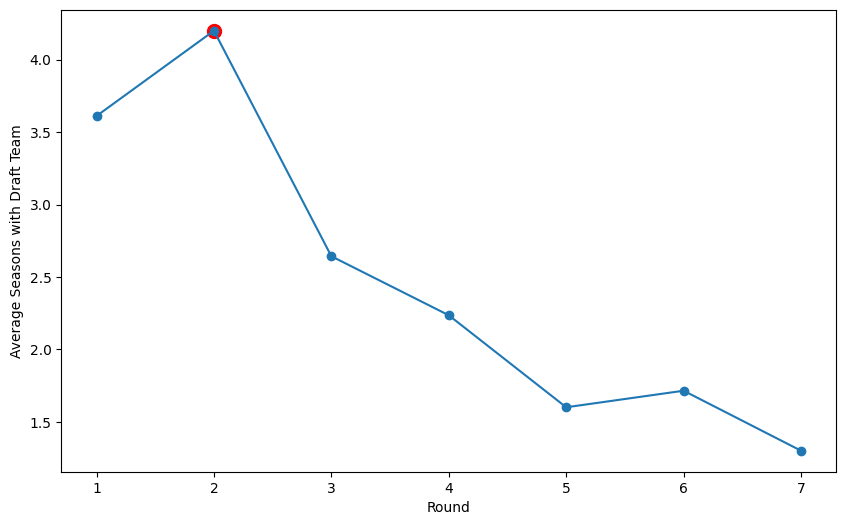

In [412]:
import matplotlib.pyplot as plt

means = final.groupby('round')['seasons_with_draft_team'].mean()

plt.figure(figsize=(10, 6))
plt.plot(means.index, means.values, marker='o')

max_x = means.idxmax()
max_y = means.max()

plt.scatter(max_x, max_y, color='red', s=100)

plt.xlabel('Round')
plt.ylabel('Average Seasons with Draft Team')
plt.show()

<Axes: xlabel='Y/G', ylabel='Density'>

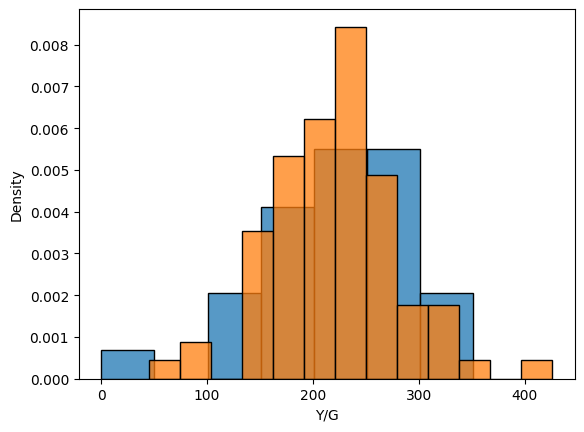

In [427]:
sns.histplot(data=final[final.seasons_with_draft_team >=4], x='Y/G', stat='density')
sns.histplot(data=final[final.seasons_with_draft_team < 4], x='Y/G', stat='density')

<Axes: xlabel='college_seasons', ylabel='count'>

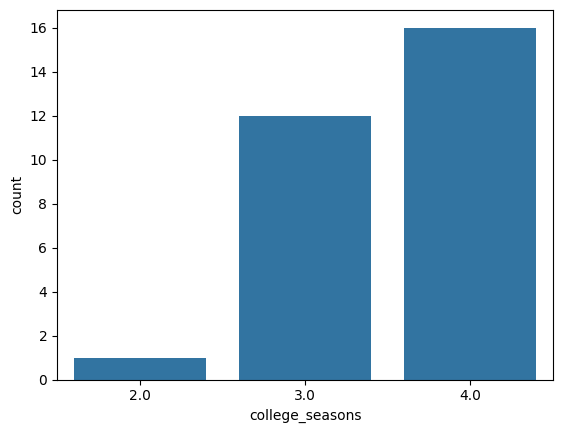

In [428]:
sns.countplot(final[final.seasons_with_draft_team >=4], x='college_seasons')

<Axes: xlabel='college_seasons', ylabel='count'>

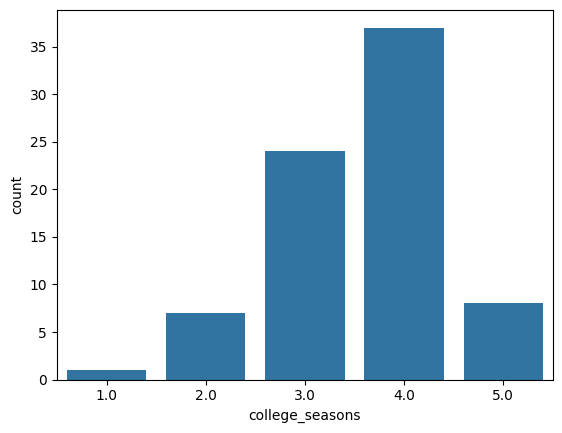

In [429]:
sns.countplot(final[final.seasons_with_draft_team < 4], x='college_seasons')

In [444]:
positive_samples = final[final['seasons_with_draft_team'] >= 4]
negative_samples = final[final['seasons_with_draft_team'] < 4]

<Axes: >

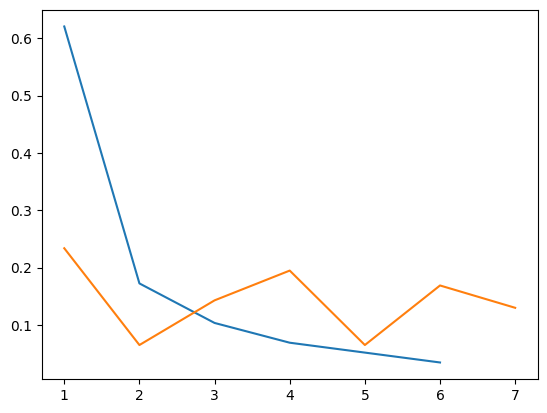

In [450]:
positive_samples['round'].value_counts(normalize=True).plot()
negative_samples['round'].value_counts(normalize=True).sort_index().plot()

In [452]:
final

,player_name,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,...,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,college_seasons,recent_team,seasons_with_draft_team
0,Sam Bradford,1,1,2010,31.0,604.0,893.0,67.6,8403.0,88.0,...,16.0,1.8,9.4,10.57,13.9,271.1,175.6,3.0,LA,4.0
1,Tim Tebow,1,25,2010,55.0,661.0,995.0,66.4,9285.0,88.0,...,16.0,1.6,9.3,10.38,14.0,168.8,170.8,4.0,DEN,2.0
2,Jimmy Clausen,2,48,2010,35.0,695.0,1110.0,62.6,8148.0,60.0,...,27.0,2.4,7.3,7.33,11.7,232.8,137.2,3.0,CAR,1.0
3,Colt McCoy,3,85,2010,53.0,1157.0,1645.0,70.3,13253.0,112.0,...,45.0,2.7,8.1,8.19,11.5,250.1,155.0,4.0,CLE,3.0
4,Mike Kafka,4,122,2010,30.0,408.0,637.0,64.1,4265.0,19.0,...,20.0,3.1,6.7,5.88,10.5,142.2,123.9,4.0,PHI,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,C.J. Beathard,3,104,2017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,Joshua Dobbs,4,135,2017,37.0,614.0,999.0,61.5,7138.0,53.0,...,29.0,2.9,7.1,6.90,11.6,192.9,133.2,4.0,PIT,2.0
146,Nathan Peterman,5,171,2017,36.0,398.0,663.0,60.0,5236.0,47.0,...,17.0,2.6,7.9,8.16,13.2,145.4,144.6,4.0,BUF,2.0
147,Brad Kaaya,6,215,2017,38.0,721.0,1189.0,60.6,9972.0,69.0,...,24.0,2.0,8.4,8.64,13.8,262.4,146.2,3.0,NaN,NaN


In [459]:
KMeans(n_clusters=3)

KMeans(n_clusters=3)

In [462]:
KMeans(n_clusters=3).fit(X=final.select_dtypes(exclude='object').dropna())

KMeans(n_clusters=3)

In [465]:
negative_samples.describe()

,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,college_seasons,seasons_with_draft_team
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,3.818182,116.090909,2016.753247,38.142857,663.025974,1048.922078,63.274026,8378.701299,64.987013,6.333766,23.207792,2.212987,8.071429,8.345195,12.759740,221.028571,147.588312,3.571429,1.727273
std,2.107176,79.028506,3.773717,9.439160,238.010668,374.663279,4.024118,2786.211425,23.868882,1.728751,10.322864,0.549725,0.945885,1.389314,1.133957,60.453496,16.562791,0.849591,0.771812
min,1.000000,1.000000,2010.000000,12.000000,91.000000,167.000000,54.500000,1107.000000,6.000000,2.900000,6.000000,1.200000,6.300000,5.460000,10.300000,45.600000,113.600000,1.000000,1.000000
25%,2.000000,48.000000,2014.000000,31.000000,513.000000,813.000000,60.800000,6284.000000,49.000000,5.200000,16.000000,1.800000,7.300000,7.350000,11.900000,185.900000,136.300000,3.000000,1.000000
50%,4.000000,110.000000,2017.000000,38.000000,650.000000,1002.000000,62.900000,8385.000000,63.000000,6.200000,22.000000,2.100000,8.000000,8.230000,12.900000,224.700000,145.700000,4.000000,2.000000
75%,6.000000,185.000000,2020.000000,46.000000,791.000000,1261.000000,66.300000,9899.000000,81.000000,7.300000,28.000000,2.600000,8.700000,9.140000,13.400000,252.500000,157.200000,4.000000,2.000000
max,7.000000,262.000000,2022.000000,56.000000,1404.000000,2183.000000,74.300000,16646.000000,123.000000,12.700000,52.000000,4.200000,11.000000,12.700000,15.700000,426.200000,199.400000,5.000000,3.000000


In [463]:
positive_samples.describe()

,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,college_seasons,seasons_with_draft_team
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,1.758621,34.310345,2013.965517,39.827586,695.310345,1093.103448,64.851724,8848.034483,70.172414,9.810345,24.655172,2.231034,8.244828,9.201034,12.768966,224.572414,162.003448,3.517241,5.482759
std,1.243703,45.774372,2.821888,8.332676,262.743235,401.645219,7.737369,3163.645157,28.602034,17.427326,9.882437,0.675121,0.983284,4.036016,1.421796,71.747319,68.010317,0.574499,1.844310
min,1.000000,1.000000,2010.000000,20.000000,1.000000,1.000000,54.000000,9.000000,1.000000,4.100000,0.000000,0.000000,6.400000,6.210000,9.000000,0.200000,119.100000,2.000000,4.000000
25%,1.000000,2.000000,2012.000000,36.000000,585.000000,891.000000,61.700000,7598.000000,50.000000,5.200000,20.000000,2.000000,7.800000,7.880000,11.800000,191.300000,138.100000,3.000000,4.000000
50%,1.000000,12.000000,2013.000000,40.000000,723.000000,1147.000000,64.600000,9131.000000,69.000000,6.400000,27.000000,2.300000,8.100000,8.430000,12.800000,227.800000,147.200000,4.000000,5.000000
75%,2.000000,39.000000,2016.000000,47.000000,857.000000,1349.000000,66.900000,10796.000000,90.000000,7.600000,30.000000,2.700000,8.900000,9.410000,13.900000,271.100000,162.800000,4.000000,6.000000
max,6.000000,180.000000,2019.000000,51.000000,1187.000000,1838.000000,100.000000,14607.000000,131.000000,100.000000,54.000000,3.300000,10.400000,29.000000,15.400000,351.600000,505.600000,4.000000,10.000000


<Axes: >

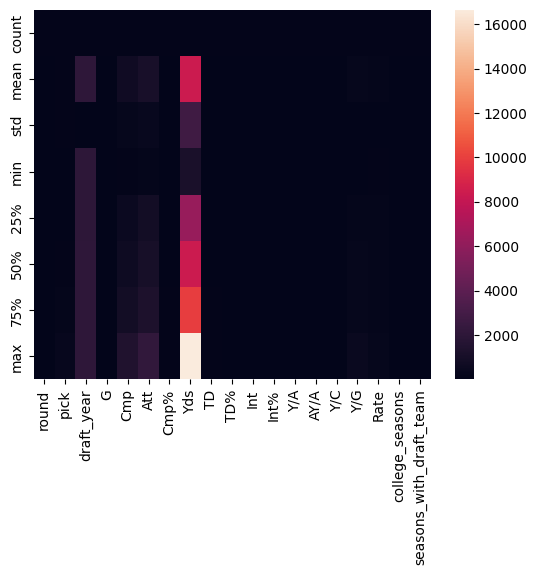

In [464]:
sns.heatmap(negative_samples.describe())

<Axes: >

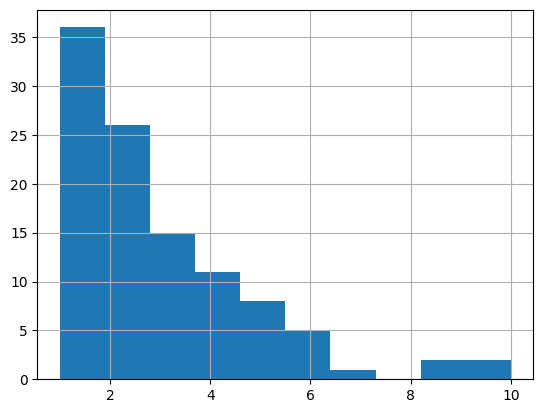

In [470]:
final_with_responses['seasons_with_draft_team'].hist()

<Axes: >

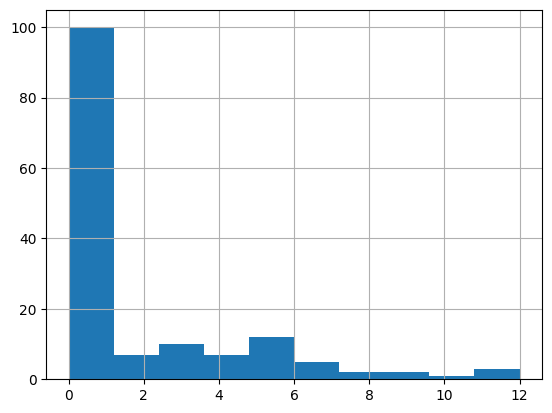

In [469]:
final_with_responses['seasons_started'].hist()

In [554]:
first_rounders = final_with_responses[final_with_responses['round'] == 1]

<Axes: xlabel='draft_year'>

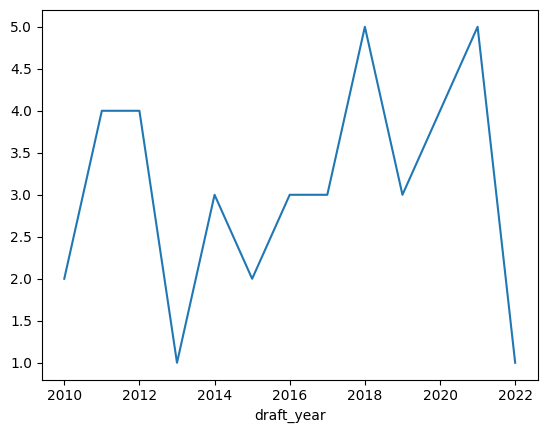

In [556]:
first_rounders.groupby('draft_year')['player_name'].count().plot()

<Axes: >

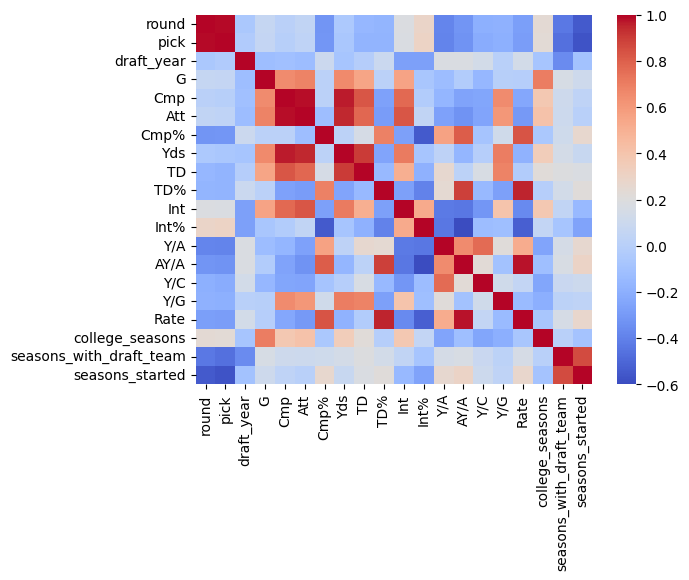

In [561]:
sns.heatmap(final_with_responses.select_dtypes(exclude='object').corr(), cmap='coolwarm')

In [568]:
pick_start = pd.DataFrame(final_with_responses.groupby('pick')['seasons_started'].mean().reset_index())

<Axes: xlabel='pick', ylabel='seasons_started'>

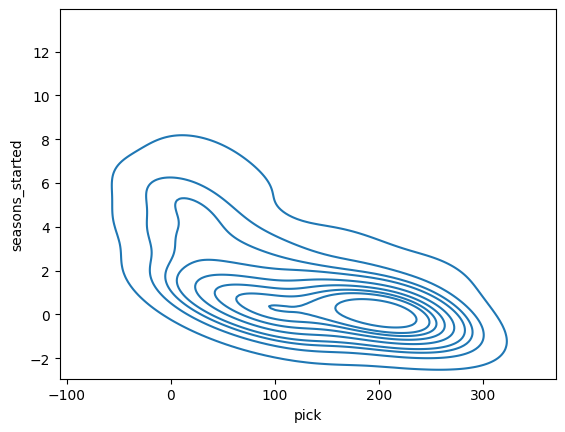

In [570]:
sns.kdeplot(x=pick_start['pick'], y=pick_start['seasons_started'])

<Axes: xlabel='pick', ylabel='Density'>

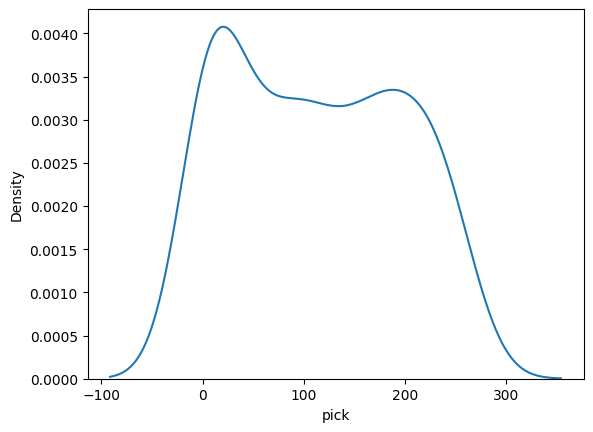

In [571]:
sns.kdeplot(data=final_with_responses, x='pick')

In [576]:
final_with_responses.select_dtypes(exclude='object')

,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,Y/A,AY/A,Y/C,Y/G,Rate,college_seasons,seasons_with_draft_team,seasons_started
0,1,1,2010,31.0,604.0,893.0,67.6,8403.0,88.0,9.9,16.0,1.8,9.4,10.57,13.9,271.1,175.6,3.0,4.0,5
1,1,25,2010,55.0,661.0,995.0,66.4,9285.0,88.0,8.8,16.0,1.6,9.3,10.38,14.0,168.8,170.8,4.0,2.0,1
2,2,48,2010,35.0,695.0,1110.0,62.6,8148.0,60.0,5.4,27.0,2.4,7.3,7.33,11.7,232.8,137.2,3.0,1.0,1
3,3,85,2010,53.0,1157.0,1645.0,70.3,13253.0,112.0,6.8,45.0,2.7,8.1,8.19,11.5,250.1,155.0,4.0,3.0,2
4,4,122,2010,30.0,408.0,637.0,64.1,4265.0,19.0,3.0,20.0,3.1,6.7,5.88,10.5,142.2,123.9,4.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,3,104,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
145,4,135,2017,37.0,614.0,999.0,61.5,7138.0,53.0,5.3,29.0,2.9,7.1,6.90,11.6,192.9,133.2,4.0,2.0,0
146,5,171,2017,36.0,398.0,663.0,60.0,5236.0,47.0,7.1,17.0,2.6,7.9,8.16,13.2,145.4,144.6,4.0,2.0,0
147,6,215,2017,38.0,721.0,1189.0,60.6,9972.0,69.0,5.8,24.0,2.0,8.4,8.64,13.8,262.4,146.2,3.0,NaN,0


Text(0, 0.5, 'Avg. Rate')

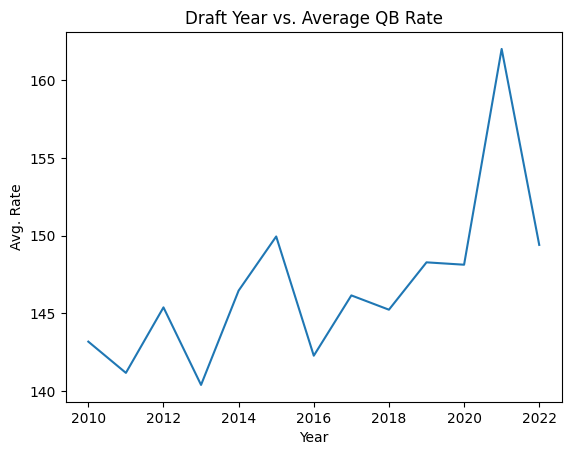

In [587]:
no_JA.groupby('draft_year')['Rate'].mean().plot()
plt.title("Draft Year vs. Average QB Rate")
plt.xlabel("Year")
plt.ylabel("Avg. Rate")

In [599]:
no_JA.groupby('draft_year').agg({'Rate':'max', 'player_name':'first'}).reset_index()

,draft_year,Rate,player_name
0,2010,175.6,Sam Bradford
1,2011,178.2,Cam Newton
2,2012,162.8,Andrew Luck
3,2013,153.5,EJ Manuel
4,2014,164.1,Blake Bortles
5,2015,171.8,Jameis Winston
6,2016,161.0,Jared Goff
7,2017,157.5,Mitchell Trubisky
8,2018,175.4,Baker Mayfield
9,2019,181.3,Kyler Murray


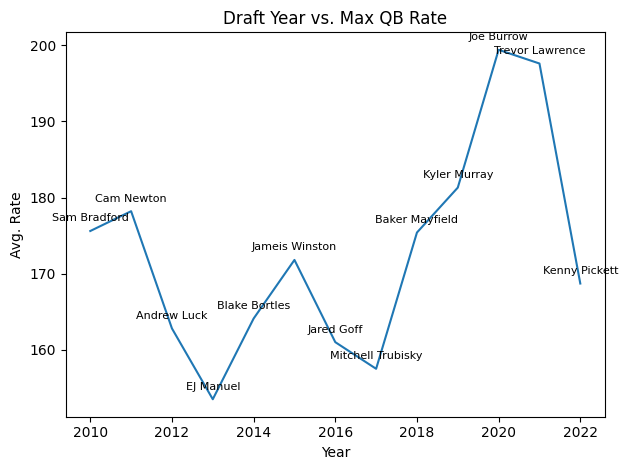

In [613]:
import matplotlib.pyplot as plt

# Plotting the line
no_JA.groupby('draft_year').agg({'Rate':'max', 'player_name':'first'}).reset_index().plot(x='draft_year', y='Rate', kind='line', legend=False)
plt.title("Draft Year vs. Max QB Rate")
plt.xlabel("Year")
plt.ylabel("Avg. Rate")

# Annotating each point with the player's name
for i, row in no_JA.groupby('draft_year').agg({'Rate':'max', 'player_name':'first'}).reset_index().iterrows():
    plt.text(row['draft_year'], row['Rate'] + 1, row['player_name'], 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


/var/folders/87/rbsvb18s08x2_20r3q58gdjw0000gn/T/ipykernel_79252/3639823085.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  no_JA.groupby('draft_year')['Rate', 'player_name'].max().plot()


Text(0, 0.5, 'Avg. Rate')

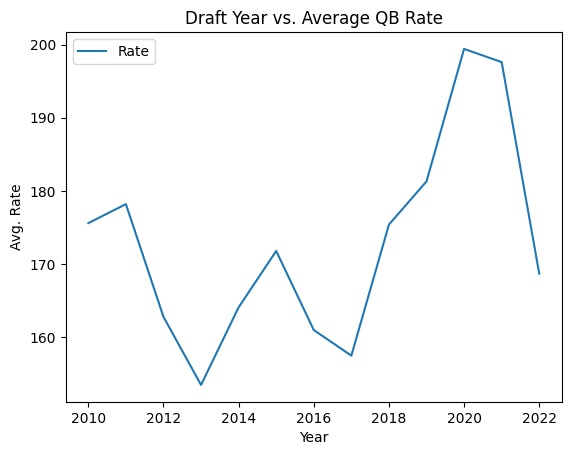

In [591]:
no_JA.groupby('draft_year')['Rate', 'player_name'].max().plot()
plt.title("Draft Year vs. Average QB Rate")
plt.xlabel("Year")
plt.ylabel("Avg. Rate")

In [589]:
max(no_JA.Rate)

199.4

In [657]:
no_JA['response'] = no_JA['seasons_started'].apply(map_seasons_started)

/var/folders/87/rbsvb18s08x2_20r3q58gdjw0000gn/T/ipykernel_79252/2674782408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_JA['response'] = no_JA['seasons_started'].apply(map_seasons_started)


In [620]:
max_pick = final_with_responses.groupby('draft_year')['pick'].min().reset_index()

In [634]:
responses_by_first = final_with_responses[(final_with_responses['pick'].isin(max_pick['pick'])) & (final_with_responses['draft_year'].isin(max_pick['draft_year']))]


In [630]:
responses_by_first

,response,player_name
0,0,3
1,1,16


In [640]:
all_qbs['college'].value_counts()

Oklahoma             5
Alabama              4
North Dakota St.     3
USC                  3
Texas A&M            3
                    ..
SMU                  1
TCU                  1
Colorado St.         1
Northern Illinois    1
Miami (FL)           1
Name: college, Length: 84, dtype: int64

Text(0.5, 1.0, '% of First Picked QBs since 2010 who started more than 3 years')

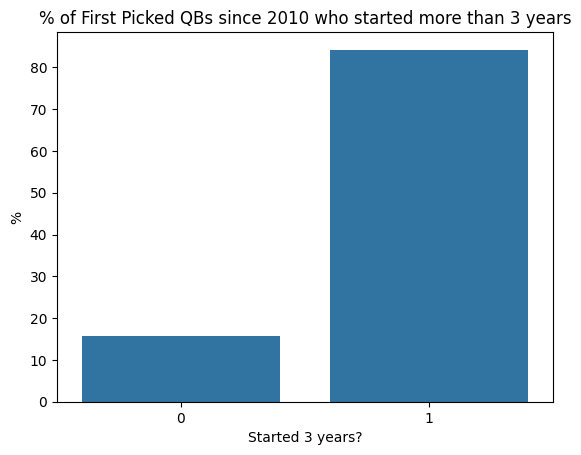

In [642]:
sns.countplot(data=responses_by_first, x='response', stat='percent')
plt.xlabel("Started 3 years?")
plt.ylabel("%")
plt.title("% of First Picked QBs since 2010 who started more than 3 years")

In [643]:
responses_by_first

,player_name,round,pick,draft_year,G,Cmp,Att,Cmp%,Yds,TD,...,AY/A,Y/C,Y/G,Rate,college_seasons,recent_team,seasons_with_draft_team,pfr_player_name,seasons_started,response
0,Sam Bradford,1,1,2010,31.0,604.0,893.0,67.6,8403.0,88.0,...,10.57,13.9,271.1,175.6,3.0,LA,4.0,Sam Bradford,5,1
13,Cam Newton,1,1,2011,20.0,191.0,292.0,65.4,2908.0,30.0,...,10.93,15.2,145.4,178.2,3.0,CAR,10.0,Cam Newton,9,1
25,Andrew Luck,1,1,2012,38.0,713.0,1064.0,67.0,9430.0,82.0,...,9.47,13.2,248.2,162.8,3.0,IND,6.0,Andrew Luck,5,1
26,Robert Griffin III,1,2,2012,41.0,800.0,1192.0,67.1,10366.0,78.0,...,9.36,13.0,252.8,158.9,4.0,NaN,NaN,Robert Griffin III,3,1
36,EJ Manuel,1,16,2013,43.0,600.0,897.0,66.9,7741.0,47.0,...,8.27,12.9,180.0,150.4,4.0,BUF,4.0,EJ Manuel,1,0
47,Blake Bortles,1,3,2014,37.0,585.0,891.0,65.7,7598.0,56.0,...,8.82,13.0,205.4,153.8,3.0,JAX,5.0,Blake Bortles,5,1
61,Jameis Winston,1,1,2015,27.0,562.0,851.0,66.0,7964.0,65.0,...,9.41,14.2,295.0,163.3,2.0,TB,5.0,Jameis Winston,5,1
62,Marcus Mariota,1,2,2015,41.0,779.0,1167.0,66.8,10796.0,105.0,...,10.51,13.9,263.3,171.8,3.0,TEN,5.0,Marcus Mariota,5,1
68,Jared Goff,1,1,2016,37.0,977.0,1569.0,62.3,12200.0,96.0,...,8.14,12.5,329.7,144.0,3.0,LA,5.0,Jared Goff,8,1
69,Carson Wentz,1,2,2016,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carson Wentz,6,1


In [582]:
final_with_responses.groupby('draft_year')['Rate'].max()

draft_year
2010    175.6
2011    178.2
2012    162.8
2013    153.5
2014    164.1
2015    171.8
2016    161.0
2017    157.5
2018    505.6
2019    181.3
2020    199.4
2021    197.6
2022    168.7
Name: Rate, dtype: float64

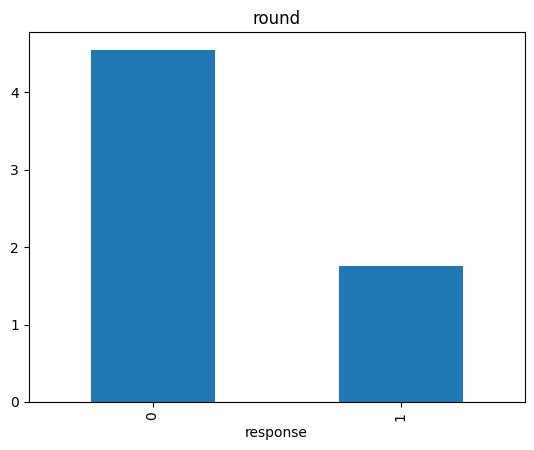

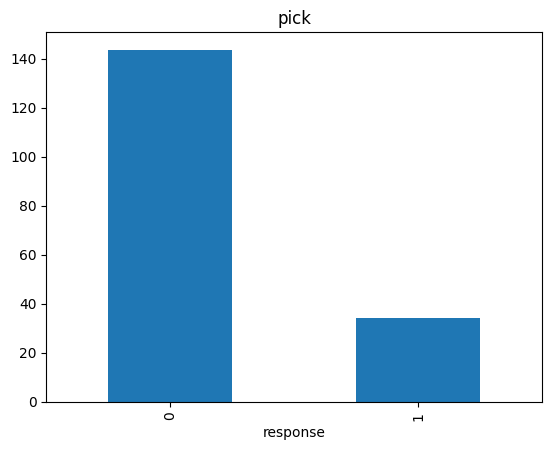

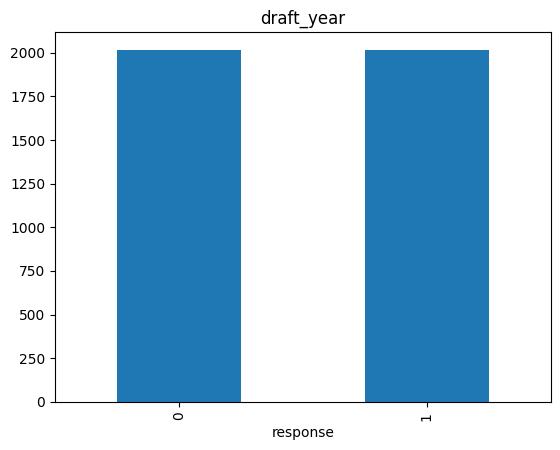

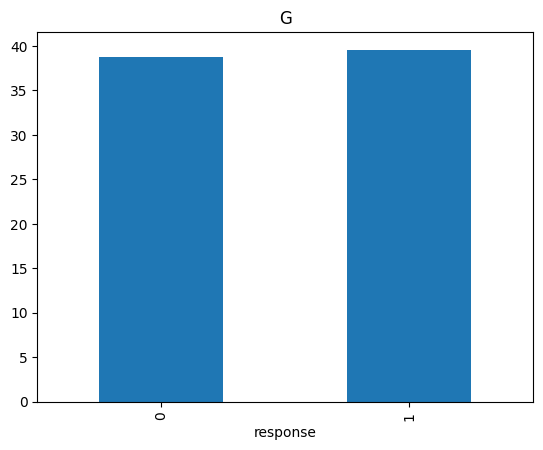

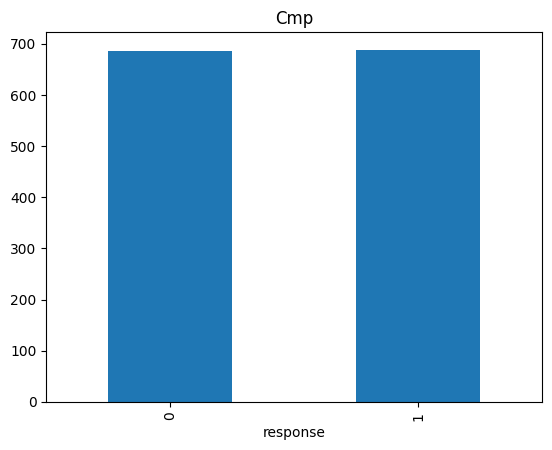

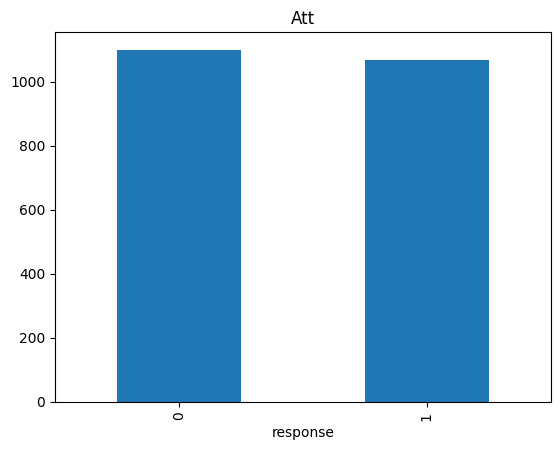

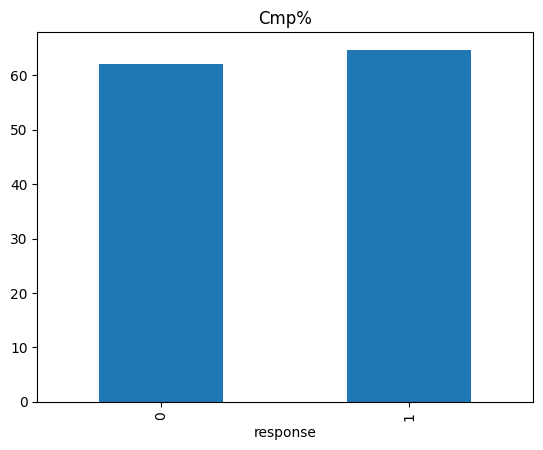

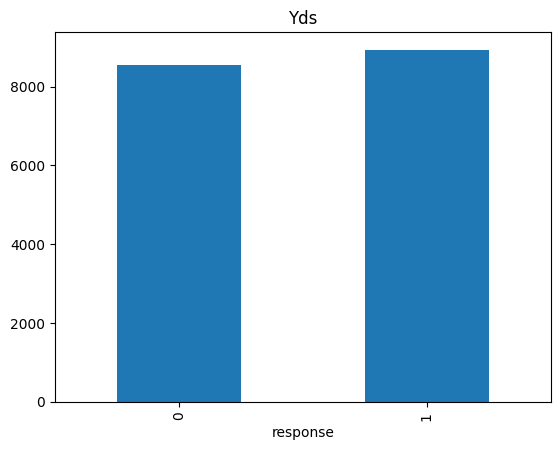

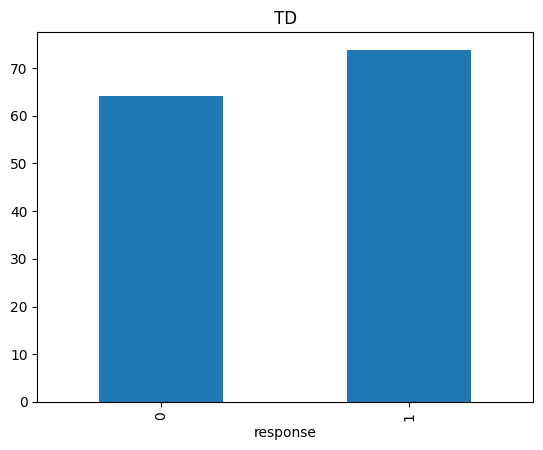

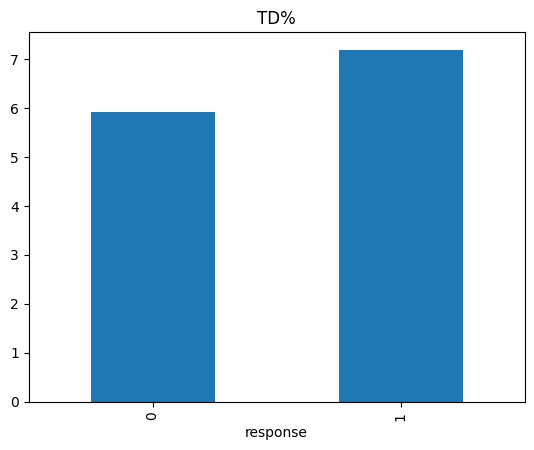

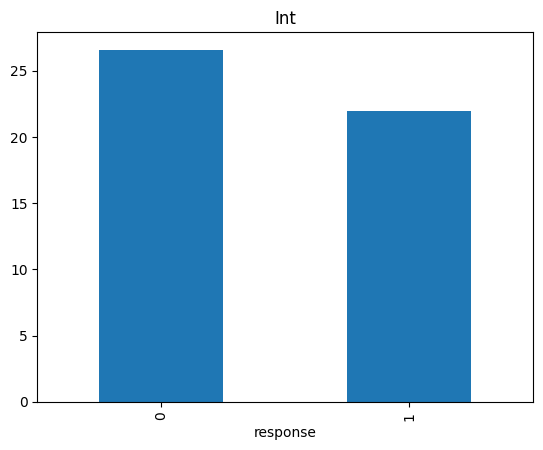

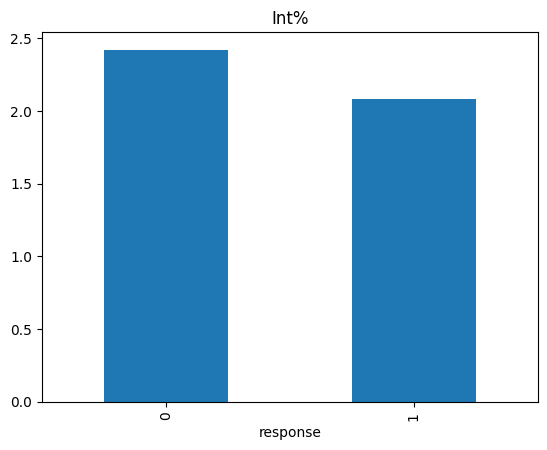

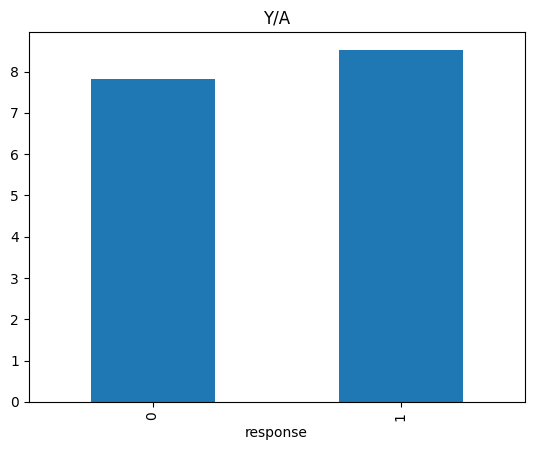

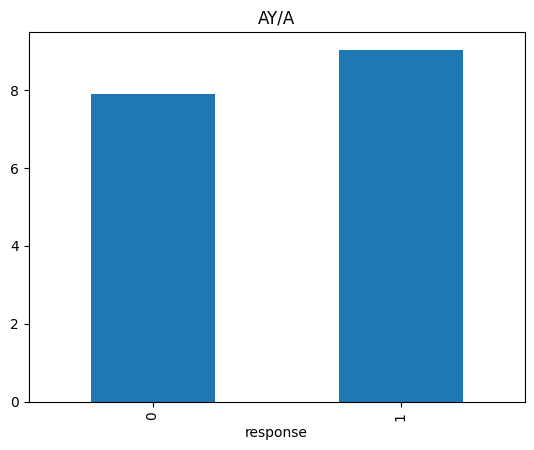

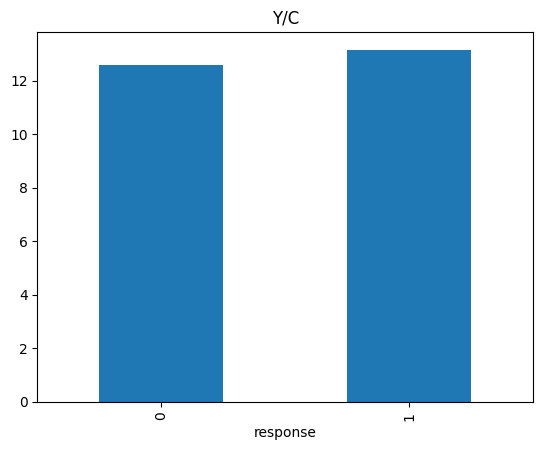

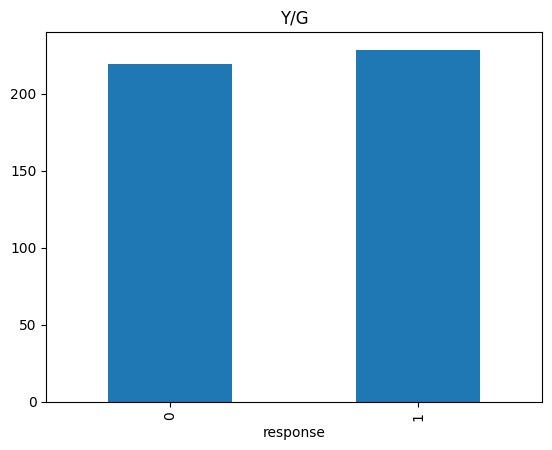

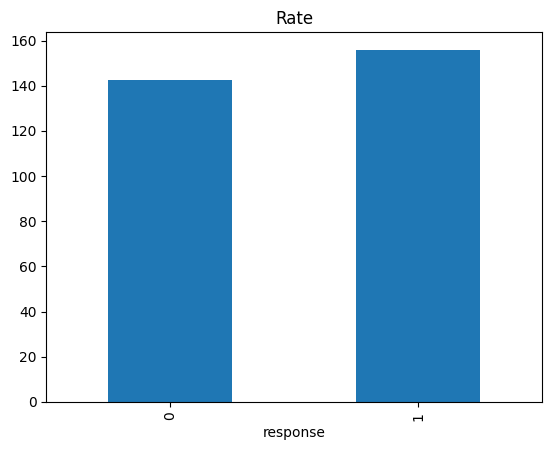

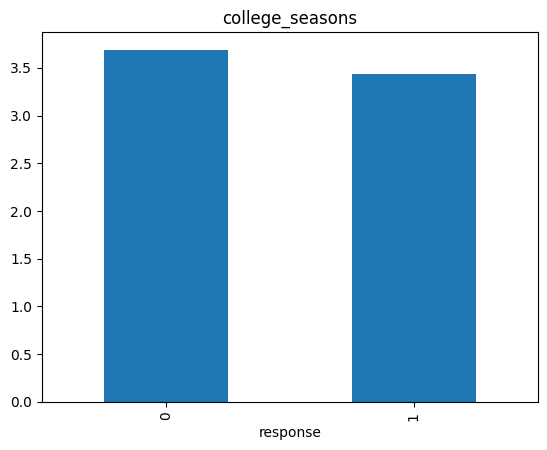

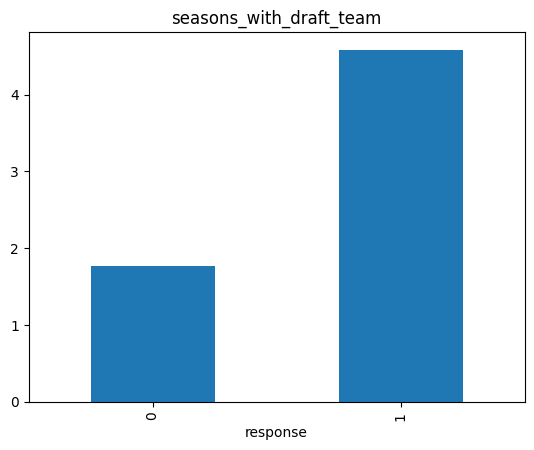

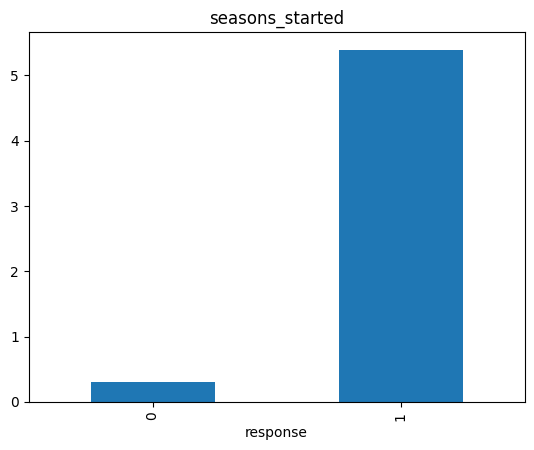

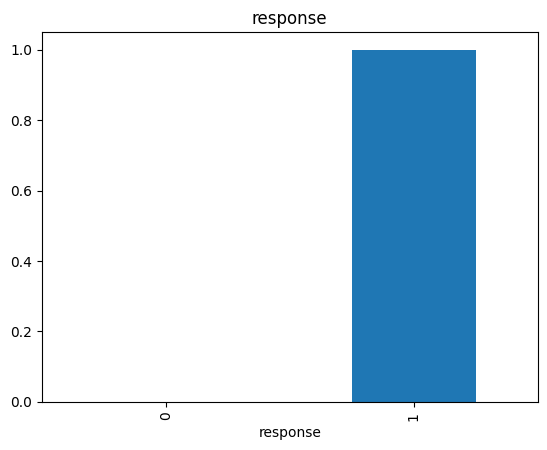

In [664]:
for col in no_JA.select_dtypes(exclude='object').columns:
    no_JA.groupby('response')[col].mean().plot.bar()
    plt.title(col)
    plt.show()